In this notebook, we compute invariant sets for the planar system with univariate input of [Example 1 of [AT19]](https://github.com/janis10/cis2m/blob/master/example2D.m).
We need to select an semidefinite programming solver to find the invariant set. A complete list of available solvers is [available here](https://www.juliaopt.org/JuMP.jl/stable/installation/#Getting-Solvers-1).

[AT19] Tzanis Anevlavis and Paulo Tabuada, "Computing controlled invariant sets in two moves", In 2019 IEEE Conference on Decision and Control (CDC).

In [1]:
using MosekTools
using JuMP
solver = with_optimizer(Mosek.Optimizer, QUIET=true)

OptimizerFactory(Mosek.Optimizer, (), Base.Iterators.Pairs(:QUIET => 1))

We first define the safe sets and input sets for our system using [Polyhedra](https://github.com/JuliaPolyhedra/Polyhedra.jl).

In [2]:
using Polyhedra
G =[ 0.9147 -0.5402
     0.2005  0.6213
    -0.8193  0.9769
    -0.4895 -0.8200
     0.7171 -0.3581
     0.8221  0.0228
     0.3993 -0.8788]
F = [0.5566
     0.8300
     0.7890
     0.3178
     0.4522
     0.7522
     0.1099]
safe_set = polyhedron(hrep(G, F), DefaultLibrary{Float64}(solver))
cheby_center, cheby_radius = chebyshevcenter(safe_set, solver)
input_set = polyhedron(convexhull([-2], [2]))

Polyhedron Interval{Int64,StaticArrays.SArray{Tuple{1},Int64,1,1},StaticArrays.Size{(1,)}}:
2-element iterator of HalfSpace{Int64,StaticArrays.SArray{Tuple{1},Int64,1,1}}:
 HalfSpace([1], 2)
 HalfSpace([-1], 2):
2-element iterator of StaticArrays.SArray{Tuple{1},Int64,1,1}:
 [2]
 [-2]

We new define the dynamic of our system and create it using [MathematicalSystems](https://github.com/JuliaReach/MathematicalSystems.jl/).

In [3]:
using MathematicalSystems
A = [1.5 1.0
     0.0 1.0]
B = reshape([0.5, 0.25], 2, 1)
using SwitchOnSafety
system = ConstrainedLinearControlDiscreteSystem(A, B, safe_set, input_set)

┌ Info: Recompiling stale cache file /home/blegat/.julia/compiled/v1.2/SwitchOnSafety/EUPLd.ji for SwitchOnSafety [ceb7f16a-07bf-5f4a-9354-b68f01b1610f]
└ @ Base loading.jl:1240


ConstrainedLinearControlDiscreteSystem{Float64,Array{Float64,2},Array{Float64,2},DefaultPolyhedron{Float64,MixedMatHRep{Float64,Array{Float64,2}},MixedMatVRep{Float64,Array{Float64,2}}},Interval{Int64,StaticArrays.SArray{Tuple{1},Int64,1,1},StaticArrays.Size{(1,)}}}([1.5 1.0; 0.0 1.0], [0.5; 0.25], HalfSpace([0.9147, -0.5402], 0.5566) ∩ HalfSpace([0.2005, 0.6213], 0.83) ∩ HalfSpace([-0.8193, 0.9769], 0.789) ∩ HalfSpace([-0.4895, -0.82], 0.3178) ∩ HalfSpace([0.7171, -0.3581], 0.4522) ∩ HalfSpace([0.8221, 0.0228], 0.7522) ∩ HalfSpace([0.3993, -0.8788], 0.1099), HalfSpace([1], 2) ∩ HalfSpace([-1], 2) : convexhull([2], [-2]))

We now compute the invariant set by searching for any ellipsoid with a given point in its interior.
As the system is reformulated into an algebraic system with safe set `safe_set * input_set`, the Chebyshev center is `(cheby_center, 0)` (note that `Polyhedra.chebyshevcenter(safe * input)` is currently incorrect because of https://github.com/JuliaPolyhedra/Polyhedra.jl/issues/125) where `cheby_center` is the Chebyshev center of `safe_set`.
To avoid having to solve Bilinear Matrix Inequalities, we set the S-procedure scaling to `1.05` (found by a few trials, checking what gives the best `objective_value`).

In [4]:
S_procedure_scaling = 1.254
S_procedure_scaling = 1.1884
cheby_center, cheby_radius = chebyshevcenter(safe_set, solver)
cheby = [cheby_center; 0.0]
cheby = zeros(3)
using SwitchOnSafety
variable = Ellipsoid(point = SetProg.InteriorPoint(cheby))
max_vol_ell = invariant_set(system, solver, variable, λ = S_procedure_scaling)

MOI.get(model, MOI.SolveTime()) = 0.00436091423034668
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.primal_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.dual_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.objective_value(model) = 0.09476732149283565


SetProg.Sets.Translation{SetProg.Sets.Polar{Float64,SetProg.Sets.EllipsoidAtOrigin{Float64}},Float64,Array{Float64,1}}(SetProg.Sets.Polar{Float64,SetProg.Sets.EllipsoidAtOrigin{Float64}}(SetProg.Sets.EllipsoidAtOrigin{Float64}([0.17409204611350196 0.03892787871104693; 0.03892787871104693 0.1498521775804338])), [-0.13511104266324797, 0.20139098031749464])

Instead of maximizing the volume, we can maximize the L1 norm.

In [5]:
using SwitchOnSafety
max_tr_ell = invariant_set(system, solver, variable, λ = 1.181, volume_heuristic = ell -> L1_heuristic(ell, ones(3)))

MOI.get(model, MOI.SolveTime()) = 0.0024411678314208984
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.primal_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.dual_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.objective_value(model) = 2.352694745261778


SetProg.Sets.Translation{SetProg.Sets.Polar{Float64,SetProg.Sets.EllipsoidAtOrigin{Float64}},Float64,Array{Float64,1}}(SetProg.Sets.Polar{Float64,SetProg.Sets.EllipsoidAtOrigin{Float64}}(SetProg.Sets.EllipsoidAtOrigin{Float64}([0.08563160251486523 0.06968318528875672; 0.06968318528875672 0.06397734650127397])), [0.022475150120452328, 0.0205519904018653])

We can see that we get a larger ellipsoids for the volume maximization but not for the L1 norm as maximizing the L1 integral over the hypercube centered at the origin is not a very good heuristic. We should instaed maximize the L1 integral over the safe set but this is not implemented yet in [SetProg](https://github.com/blegat/SetProg.jl).

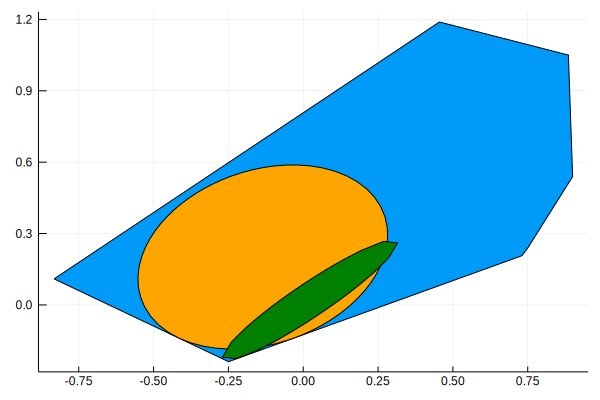

In [6]:
using Plots
plot(safe_set)
plot!(project(max_vol_ell, 1:2), color=:orange)
plot!(project(max_tr_ell, 1:2), color=:green)